<a href="https://colab.research.google.com/github/MarcosRMG/Estatisticas-de-Futebol/blob/main/Estatisticas_do_Futebol.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1 Bibliotecas

In [72]:
#!pip install --upgrade pandas

In [73]:
#!pip install --upgrade pandas_profiling

In [74]:
#!pip install category_encoders

In [1]:
# Leitura e tratamento dos dados
import pandas as pd
import requests
from urllib.request import urlopen
from bs4 import BeautifulSoup
import numpy as np

# Autocorrelação
from statsmodels.graphics.tsaplots import plot_acf

# Visualização de dados
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
#from pandas_profiling import ProfileReport
#import graphviz
from sklearn.tree import plot_tree
import plotly.express as px


# Modelos de Machine Learning
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# Métodos de extratificação dos dados
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GroupKFold
from sklearn import tree

# Métricas 
from sklearn import metrics
from ipywidgets import widgets, HBox, VBox
from IPython.display import display

# Preprocessamento
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import OneHotEncoder

# Modelos
from sklearn.tree import DecisionTreeRegressor

# Feature selection
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

# Seleção de parâmetros
from sklearn.model_selection import GridSearchCV

# Pipeline
from sklearn.pipeline import Pipeline

# Testes
from statsmodels.stats.weightstats import DescrStatsW
from scipy.stats import normaltest

# Probabilidade
from scipy.stats import norm

In [12]:
# Personaliza visualizações
matplotlib.rcParams['font.size'] = 12
matplotlib.rcParams['figure.figsize'] = [12, 6]
sns.set_style(style='darkgrid')

# 2 Funções

## 2.1 Personaliza gráfico

In [77]:
def personaliza_grafico(titulo: str, eixo_x: str, eixo_y: str):
  plt.title(titulo, loc='left', fontsize=24, y=1.1)
  plt.xlabel(eixo_x, fontsize=14)
  plt.ylabel(eixo_y, fontsize=14);

## 2.2 Binariza coluna

In [78]:
def binariza_coluna(dados: pd.DataFrame, colunas: list()):
  '''
  Realiza a binarização da coluna

  :param dados: DataFrame com as informações para binarização
  :param colunas: Lista de colunas a ser binarizada

  return Dados binarizados para atribuição excluíndo se a coluna antiga
  '''
  dados = dados.join(pd.get_dummies(dados[colunas]))
  dados.drop(colunas, axis=1, inplace=True)
  
  return dados

## 2.3 Remove variáveis correlacionadas

In [79]:
def remove_variaveis_correlacionadas(dados: pd.DataFrame):
  '''
  --> Remove as colunas com correlação igual ou maior que 0.95

  :param dados: DataFrame para excluir a coluna com alta correlação
  '''
  alta_corr = .95
  matriz_corr = dados.corr().abs()
  matriz_corr_superior = matriz_corr.where(np.triu(np.ones(matriz_corr.shape).astype(np.bool), k=1))
  excluir = [coluna for coluna in matriz_corr_superior.columns if any(matriz_corr_superior[coluna] > alta_corr)]
  dados.drop(excluir, axis=1, inplace=True)
  print('Variáveis escluídas: ', excluir)

## 3.4 Treina modelo e checa R²

In [80]:
def treina_modelo(dados: pd.DataFrame, x: list(), y: str, 
                  modelo=LinearRegression()):
  '''
  --> Extratifica os dados e treina o modelo retornando o valor méido de R² e o
  intervalo de todas as equipes

  :param dados: DataFrame para extração dos dados de treino e teste
  :param modelo: Modelo para treino, teste e previsão
  :param x: Variáveis explicativas
  :param y: Variável dependente

  return y_previsto, y_teste, modelo
  '''
  seed = np.random.seed(323)
  dados = dados.sample(frac=1).reset_index(drop=True)
  dados.dropna(inplace=True)
  
  x = dados[x]
  y = dados[y]

  x_treino, x_teste, y_treino, y_teste = train_test_split(x, y, test_size=.3,
                                                          random_state=seed)
  
  modelo.fit(x_treino, y_treino)
  y_previsto = modelo.predict(x_teste)

  return modelo, y_previsto, y_teste

## 3.5 Previsão Pontual

In [81]:
def previsao_pontual(dados: pd.DataFrame, clube: str, modelo=LinearRegression()):
  seed = np.random.seed(323)
  dados.dropna(inplace=True)
  
  dados = dados.query('clube == @clube')
  x = dados.drop(['gols_marcados', 'clube'], axis=1)
  y = dados['gols_marcados']
  
  modelo = modelo
  modelo.fit(x, y)
  print(modelo.predict(x))

## 3.6 Tabela de frequência

In [82]:
def tabela_frequencia(dados: pd.DataFrame, coluna: str, indice=str):
  '''
  --> Calcula a tabela de frequência

  :param dados: DataFrame para calculo da frequência
  :param coluna: Coluna do DataFrame específica para cálculo
  :param indice: Descrição do índice do DataFrame
  '''
  frequencia = dados[coluna].value_counts()
  proporcao = round(dados[coluna].value_counts(normalize=True) * 100, 1)
  tabela = pd.DataFrame({'Frequência': frequencia, '%': proporcao})
  tabela.rename_axis(indice, inplace=True)
  return tabela

## 3.7 Tabela Cruzada

In [83]:
def tabela_cruzada(dados: pd.DataFrame, indice=str, coluna=str, normaliza=str,
                   titulo_indice=list(), titulo_coluna=list()):
  '''
  --> Calcula a frequência de duas variáveis cruzadas

  :param dados: DataFrame com os valores para cálculo
  :param indice: Variável a ser calculada no índice
  :param coluna: Variável a ser calculada na coluna
  :param normaliza: Método de cálculo da proporção, toda a tabela = True
  pelo índice = index, pela coluna = columns
  :param titulo_indice: Descrição das variáveis do índice
  :param titulo_coluna: Descrição das variáveis da coluna
  '''
  return (pd.crosstab(dados[indice], dados[coluna], 
            normalize=normaliza,
            rownames=[titulo_indice],
            colnames=[titulo_coluna]) * 100).round(1)

## 3.8 Roda modelo com validação cruzada

In [84]:
def roda_modelo_cv(dados: pd.DataFrame, y='gols_partida', 
                x_drop=['gols_partida'],
                modelo=DecisionTreeRegressor(), n_splits=5, n_repeats=10,
                descricao_modelo='Decision Tree Classifier'):
  '''
  Realiza a validação cruzada

  Keyword arguments
  dados: DataFrame com as informações para treino e teste
  y: Coluna do DataFrame atribuída a variável y
  x_drop: Colunas do DataFrame que devem ser desconsidradas na variável x
  modelo: Modelo para classificação
  n_splits: Número de partes que o DataFrame será divido para validação 
  n_repeats: Número de vezes que o modelo será treinado
  descricao_modelo: Descrição do modelo utilizado

  return: Média do auc de teste e de treino
  '''
  
  np.random.seed(723)
  dados = dados.sample(frac=1).reset_index(drop=True)
  y = dados[y]
  x = dados.drop(x_drop, axis=1)

  modelo = modelo
  
  cv = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats)
  resultado = cross_validate(modelo, x, y, cv=cv, scoring='accuracy', 
                             return_train_score=True)

  media_teste = np.mean(resultado['test_score'])
  media_treino = np.mean(resultado['train_score'])

  print(f'Acurácia teste/ treino: {media_teste:.2f} - {media_treino:.2f}')

## 3.9 Roda modelo

In [85]:
def roda_modelo(x: list(), y: list(), 
                modelo=DecisionTreeRegressor()):
  '''
  --> Roda o modelo sem validação cruzada

  :param dados: DataFrame com os dados de teste e treino
  :param x: Features do modelo
  :param y: Label do modelo para previsão
  :modelo: Modelo de Machine Learning

  return modelo, y_previsto, x_treino
  '''
  seed = np.random.seed(723)

  modelo = modelo

  x_treino, x_teste, y_treino, y_teste = train_test_split(x, y, random_state=seed,
                                                        train_size=.7)
  
  modelo.fit(x_treino, y_treino)
  modelo.predict(x_teste)

  print(f'Acurácia: {metrics.accuracy_score(y_teste, x_teste).round(2)}')
  return modelo, y_previsto, x_treino

# 3 Dados

## 3.1 Dados resumidos

In [2]:
# Liga Italiana
fonte_liga_italiana = 'https://raw.githubusercontent.com/MarcosRMG/Estatisticas-de-Futebol/main/dados/italiano/rodadas_liga.csv'

In [3]:
liga_italiana = pd.read_csv(fonte_liga_italiana)
liga_italiana.head()

,Unnamed: 0,clube,data,rodada,local,resultado,gols_marcados,gols_sofridos,oponente,posse,...,total_chutes,chutes_a_gol_%,chutes_por_gol,cartoes_amarelos,cartoes_vermelhos,faltas_cometidas,chutes_contra_o_gol,defesas_%,sem_vazamento,escudo
0,0,Inter,2021-03-14,27,Visitante,V,2.0,1.0,Torino,68.0,...,12,16.7,6.0,1,0,12,3,66.7,0,https://d2p3bygnnzw9w3.cloudfront.net/req/2021...
1,1,Inter,2021-03-08,26,Em casa,V,1.0,0.0,Atalanta,45.0,...,5,20.0,5.0,0,0,17,2,100.0,1,NaN
2,2,Inter,2021-03-04,25,Visitante,V,2.0,1.0,Parma,48.0,...,12,50.0,6.0,1,0,11,2,50.0,0,NaN
3,3,Inter,2021-02-28,24,Em casa,V,3.0,0.0,Genoa,51.0,...,24,50.0,8.0,0,0,13,2,100.0,1,NaN
4,4,Inter,2021-02-21,23,Visitante,V,3.0,0.0,Milan,40.0,...,15,40.0,5.0,1,0,10,8,100.0,1,NaN


In [5]:
liga_italiana[:5]['resultado']

0    V
1    V
2    V
3    V
4    V
Name: resultado, dtype: object

In [89]:
print(f'Número de linhas: {liga_italiana.shape[0]}\nNúmero de colunas: {liga_italiana.shape[1]}')

Número de linhas: 533
Número de colunas: 21


In [90]:
liga_italiana.dtypes

clube                   object
data                    object
rodada                   int64
local                   object
resultado               object
gols_marcados          float64
gols_sofridos          float64
oponente                object
posse                  float64
gols_partida           float64
escanteios               int64
passes_certos_%        float64
total_chutes             int64
chutes_a_gol_%         float64
chutes_por_gol         float64
cartoes_amarelos         int64
cartoes_vermelhos        int64
faltas_cometidas         int64
chutes_contra_o_gol      int64
defesas_%              float64
sem_vazamento            int64
dtype: object

In [91]:
liga_italiana.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 533 entries, 0 to 532
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   clube                533 non-null    object 
 1   data                 533 non-null    object 
 2   rodada               533 non-null    int64  
 3   local                533 non-null    object 
 4   resultado            533 non-null    object 
 5   gols_marcados        533 non-null    float64
 6   gols_sofridos        533 non-null    float64
 7   oponente             533 non-null    object 
 8   posse                533 non-null    float64
 9   gols_partida         533 non-null    float64
 10  escanteios           533 non-null    int64  
 11  passes_certos_%      533 non-null    float64
 12  total_chutes         533 non-null    int64  
 13  chutes_a_gol_%       533 non-null    float64
 14  chutes_por_gol       533 non-null    float64
 15  cartoes_amarelos     533 non-null    int

In [92]:
liga_italiana.isna().sum()

clube                   0
data                    0
rodada                  0
local                   0
resultado               0
gols_marcados           0
gols_sofridos           0
oponente                0
posse                   0
gols_partida            0
escanteios              0
passes_certos_%         0
total_chutes            0
chutes_a_gol_%          0
chutes_por_gol          0
cartoes_amarelos        0
cartoes_vermelhos       0
faltas_cometidas        0
chutes_contra_o_gol     0
defesas_%              20
sem_vazamento           0
dtype: int64

In [93]:
liga_italiana.fillna(0, inplace=True)

In [10]:
liga_italiana.query('clube == "Inter" and local == "Em casa" or oponente == "Inter" and local == "Visitante"').groupby('data').sum()['escanteios']

data
2020-09-26     6
2020-10-17     8
2020-10-31    17
2020-11-22     2
2020-12-05    10
2020-12-16     7
2020-12-20     5
2021-01-03     6
2021-01-17     7
2021-01-30     7
2021-02-14     4
2021-02-28    10
2021-03-08    14
Name: escanteios, dtype: int64

### 3.1.1 Valores duplicados

Há registros duplicados, pois a mesma partida se repete para os registros de cada clube.

In [94]:
liga_italiana.query('clube == "Inter" and oponente == "Benevento"')

,clube,data,rodada,local,resultado,gols_marcados,gols_sofridos,oponente,posse,gols_partida,escanteios,passes_certos_%,total_chutes,chutes_a_gol_%,chutes_por_gol,cartoes_amarelos,cartoes_vermelhos,faltas_cometidas,chutes_contra_o_gol,defesas_%,sem_vazamento
7,Inter,2021-01-30,20,Em casa,V,4.0,0.0,Benevento,61.0,4.0,7,87.4,12,50.0,3.0,0,0,11,0,0.0,1
25,Inter,2020-09-30,1,Visitante,V,5.0,2.0,Benevento,66.0,7.0,1,90.5,18,44.4,3.6,0,0,17,6,66.7,0


# 4 Análise Exploratória

In [95]:
liga_italiana.describe().round(2)

,rodada,gols_marcados,gols_sofridos,posse,gols_partida,escanteios,passes_certos_%,total_chutes,chutes_a_gol_%,chutes_por_gol,cartoes_amarelos,cartoes_vermelhos,faltas_cometidas,chutes_contra_o_gol,defesas_%,sem_vazamento
count,533.00,533.00,533.00,533.00,533.00,533.00,533.00,533.00,533.00,533.00,533.00,533.00,533.00,533.00,533.00,533.00
mean,13.95,1.51,1.50,50.02,3.02,4.89,80.28,12.24,33.76,6.25,2.24,0.09,15.55,4.07,63.44,0.23
std,7.76,1.24,1.24,9.17,1.65,2.90,5.57,5.38,15.24,5.59,1.29,0.29,4.12,2.37,31.45,0.43
min,1.00,0.00,0.00,27.00,0.00,0.00,58.70,1.00,0.00,0.00,0.00,0.00,3.00,0.00,-100.00,0.00
25%,7.00,1.00,1.00,44.00,2.00,3.00,76.60,8.00,23.50,2.00,1.00,0.00,13.00,2.00,50.00,0.00
50%,14.00,1.00,1.00,50.00,3.00,4.00,81.40,12.00,33.30,5.00,2.00,0.00,15.00,4.00,66.70,0.00
75%,21.00,2.00,2.00,56.00,4.00,7.00,84.40,15.00,43.80,9.00,3.00,0.00,18.00,6.00,87.50,0.00
max,27.00,6.00,6.00,73.00,8.00,15.00,91.90,33.00,100.00,33.00,7.00,2.00,31.00,13.00,100.00,2.00


In [96]:
mask = np.zeros_like(liga_italiana.corr())
mask[np.triu_indices_from(mask)] = True

plt.figure(figsize=(16, 8))
sns.heatmap(liga_italiana.corr().round(2), cmap='Blues', annot=True, mask=mask,
            center=0);

In [97]:
#profile = ProfileReport(liga_italiana, title='Pandas Profiling Report',
#                        explorative=True, html={'style': {'full_width': True}})

In [98]:
profile

default


/usr/local/lib/python3.7/dist-packages/IPython/core/magics/basic.py:300: UserWarning: %profile is now deprecated. Please use get_ipython().profile instead.
  warn("%profile is now deprecated. Please use get_ipython().profile instead.")


In [99]:
#profile.to_file('analise_exploratoria_liga_italiana.html')

## 4.1 Gols partida

In [100]:
inter = liga_italiana.query('clube == "Inter"')

In [101]:
sns.histplot(data=inter, x='gols_partida')
plt.title('Gols das partidas da Inter', loc='left', fontsize=18);

In [102]:
sns.boxplot(data=inter, x='gols_partida')
plt.title('Gols das partidas da Inter', loc='left', fontsize=18);

In [103]:
sns.histplot(data=inter, x='gols_partida', cumulative=True, stat='density')
plt.title('Gols das partidas da Inter', loc='left', fontsize=18);

In [104]:
liga_italiana['gols_partida'].min()

0.0

<AxesSubplot:xlabel='gols_partida', ylabel='Count'>

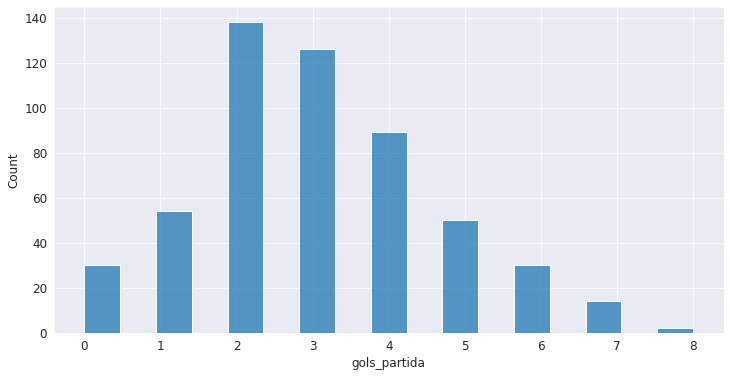

In [13]:
sns.histplot(data=liga_italiana, x='gols_partida')

In [4]:
liga_italiana['log_gols_partida'] = np.log(liga_italiana['gols_partida'] + 1)

<AxesSubplot:xlabel='log_gols_partida', ylabel='Count'>

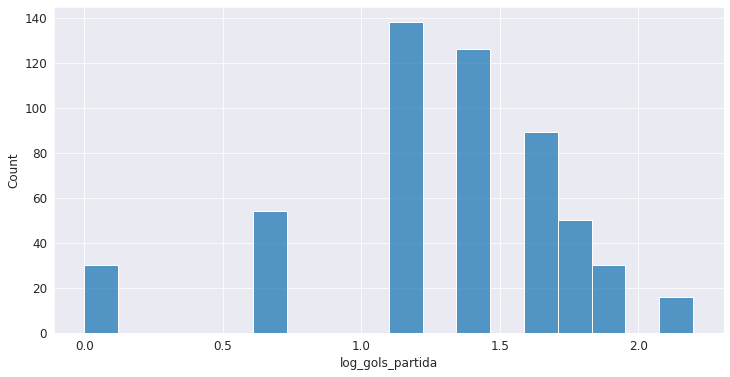

In [14]:
sns.histplot(data=liga_italiana, x='log_gols_partida')

In [25]:
print('Média log gols partida: ',liga_italiana['log_gols_partida'].mean())
print('Mediana log gols partida: ',liga_italiana['log_gols_partida'].median())
print('Moda log gols partida: ',liga_italiana['log_gols_partida'].mode())

Média log gols partida:  1.2916011556574662
Mediana log gols partida:  1.3862943611198906
Moda log gols partida:  0    1.098612
dtype: float64


In [36]:
_, p_value = normaltest(liga_italiana['log_gols_partida'])
print(f'P-value: {p_value:.2f}')
print(f'P-value < 0.05: {p_value < 0.05}')

P-value: 0.00
P-value < 0.05: True


In [6]:
std_log_gols_partida = liga_italiana['log_gols_partida'].std()
media_log_gols_partida = liga_italiana['log_gols_partida'].mean()

In [57]:
std_gols_partida = liga_italiana['gols_partida'].std()
media_gols_partida = liga_italiana['gols_partida'].mean()

In [61]:
std_log_gols_partida

0.47558603390743603

In [21]:
z_log = (np.log(3) - media_log_gols_partida) / std_log_gols_partida
z_log

-0.4057917037717684

In [28]:
z_normal = (3 - liga_italiana['gols_partida'].mean()) / liga_italiana['gols_partida'].std()
print(f'Chances de sair menos de 3 gols na partida (sem transformação): {round(norm.cdf(z_normal) * 100)} %')

Chances de sair menos de 3 gols na partida (sem transformação): 50 %


In [29]:
z_log = (np.log(3) - media_log_gols_partida) / std_log_gols_partida
print(f'Chances de sair menos de 3 gols na partida (com transformação): {round(norm.cdf(z_normal) * 100)} %')

Chances de sair menos de 3 gols na partida (com transformação): 50 %


In [43]:
z_log = (np.log(5) - media_log_gols_partida) / std_log_gols_partida
print(f'Probabilidade + 5 gols na partida (com transformação): {round(1 - norm.cdf(z_log), 2) * 100} %')

Probabilidade + 5 gols na partida (com transformação): 25.0 %


In [36]:
1 - norm.cdf(z_log)

0.6575521725357734

In [49]:
for gol in range(1, 10):
    print(f'Menos de {gol}: {norm.cdf((np.log(gol) - media_log_gols_partida) / std_log_gols_partida) * 100:.2f}%')

Menos de 1: 0.33%
Menos de 2: 10.41%
Menos de 3: 34.24%
Menos de 4: 57.89%
Menos de 5: 74.80%
Menos de 6: 85.35%
Menos de 7: 91.56%
Menos de 8: 95.12%
Menos de 9: 97.16%


In [100]:
[round(norm.cdf((gol - media_gols_partida) / std_gols_partida) * 100) for gol in range(1, 7)]

[11, 27, 50, 72, 88, 96]

In [89]:
mais_de = pd.DataFrame({'Mais de': [0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5], 'Probabilidade': [round((1 - norm.cdf((gol - media_gols_partida) / std_gols_partida)) * 100) for gol in range(0, 8)], '%': ['%', '%', '%', '%', '%', '%', '%', '%']})

In [92]:
mais_de.set_index('Mais de', inplace=True)

In [106]:
fig = px.histogram(liga_italiana, y="gols_partida", histnorm='probability density', cumulative=True)
fig.show()

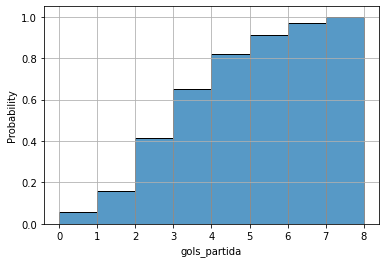

In [101]:
sns.histplot(data=liga_italiana, stat='probability', x='gols_partida', cumulative=True, bins=8)
plt.grid()

## 4.2 Escanteios

In [105]:
inter_escanteios = inter.groupby('oponente')['escanteios'].sum()

In [106]:
inter_escanteios

oponente
Atalanta         12
Benevento         8
Bologna           7
Cagliari          9
Crotone           3
Fiorentina       12
Genoa            18
Hellas Verona     8
Juventus          3
Lazio            12
Milan            10
Napoli            4
Parma            17
Roma              7
Sampdoria        10
Sassuolo          2
Spezia            3
Torino            9
Udinese           4
Name: escanteios, dtype: int64

In [107]:
sns.histplot(data=inter_escanteios.values)
plt.title('Número de escanteios nas partidas da Inter', loc='left', fontsize=18);

In [108]:
sns.boxplot(data=inter_escanteios.values, orient='h')
plt.title('Número de escanteios nas partidas da Inter', loc='left', fontsize=18);

In [109]:
sns.histplot(data=inter_escanteios.values, cumulative=True, stat='density')
plt.title('Número de escanteios nas partidas da Inter', loc='left', fontsize=18);

In [110]:
inter_escanteios.quantile(.1)

3.0

In [111]:
DescrStatsW(inter_escanteios).tconfint_mean()

(6.095097136316271, 10.53648181105215)

In [112]:
media_escanteios = inter_escanteios.mean()
desvio_padrao_escanteios = inter_escanteios.std()
(media_escanteios - desvio_padrao_escanteios, media_escanteios + desvio_padrao_escanteios)

(3.7083964824755604, 12.92318246489286)

In [113]:
media_escanteios

8.31578947368421

In [114]:
desvio_padrao_escanteios

4.60739299120865

In [27]:
liga_italiana['log_escanteios'] = np.log(liga_italiana['escanteios'] + 1)

<AxesSubplot:xlabel='escanteios', ylabel='Count'>

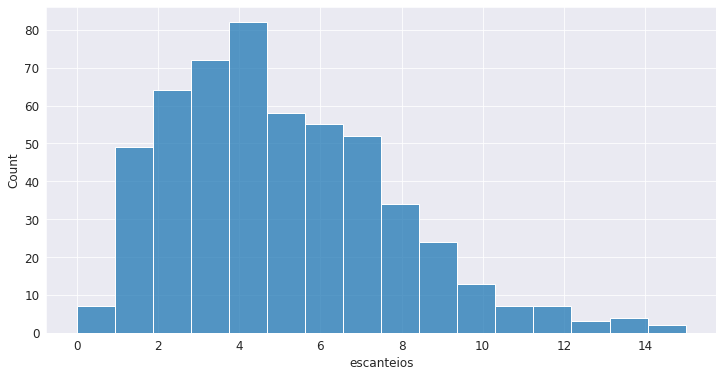

In [28]:
sns.histplot(data=liga_italiana, x='escanteios')

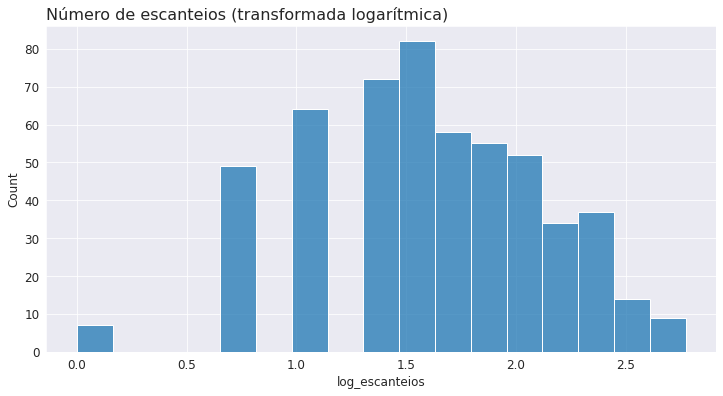

In [31]:
sns.histplot(data=liga_italiana, x='log_escanteios')
plt.title('Número de escanteios (transformada logarítmica)', loc='left', fontsize=16);

In [37]:
print('Média log escanteios: ',liga_italiana['log_escanteios'].mean())
print('Mediana log escanteios: ',liga_italiana['log_escanteios'].median())
print('Moda log gols escanteios: ',liga_italiana['log_escanteios'].mode())

Média log escanteios:  1.643385417296799
Mediana log escanteios:  1.6094379124341003
Moda log gols escanteios:  0    1.609438
dtype: float64


In [38]:
_, p_value = normaltest(liga_italiana['log_escanteios'])
print(f'P-value: {p_value:.2f}')
print(f'P-value < 0.05: {p_value < 0.05}')

P-value: 0.00
P-value < 0.05: True


## 4.3 Cartões

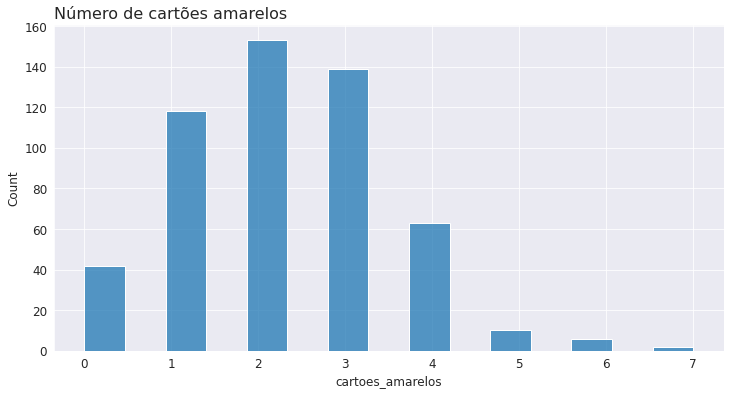

In [40]:
sns.histplot(data=liga_italiana, x='cartoes_amarelos')
plt.title('Número de cartões amarelos', loc='left', fontsize=16);

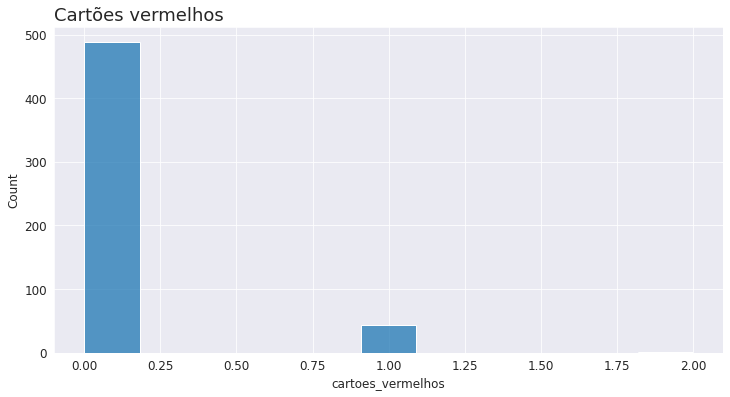

In [42]:
sns.histplot(data=liga_italiana, x='cartoes_vermelhos')
plt.title('Cartões vermelhos', loc='left', fontsize=18);

In [43]:
liga_italiana['cartoes'] = liga_italiana['cartoes_amarelos'] + liga_italiana['cartoes_vermelhos']

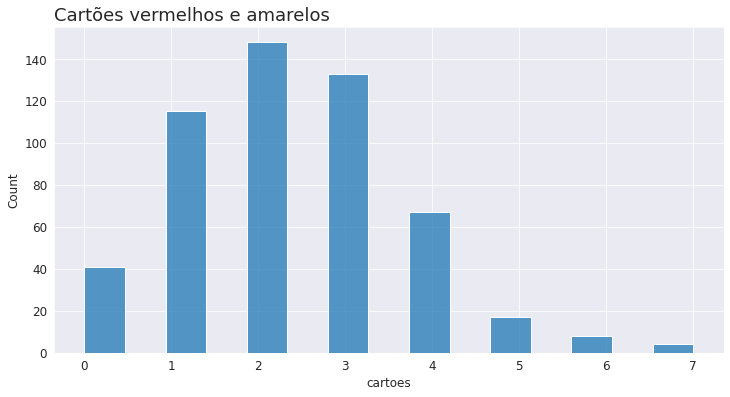

In [44]:
sns.histplot(data=liga_italiana, x='cartoes')
plt.title('Cartões vermelhos e amarelos', loc='left', fontsize=18);

In [45]:
liga_italiana['log_cartoes'] = np.log(liga_italiana['cartoes'] + 1)

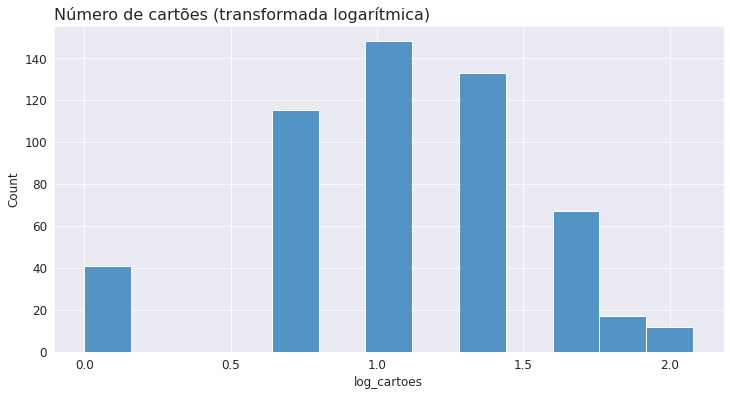

In [46]:
sns.histplot(data=liga_italiana, x='log_cartoes')
plt.title('Número de cartões (transformada logarítmica)', loc='left', fontsize=16);

In [47]:
print('Média log cartões: ',liga_italiana['log_cartoes'].mean())
print('Mediana log cartões: ',liga_italiana['log_cartoes'].median())
print('Moda log cartões: ',liga_italiana['log_cartoes'].mode())

Média log cartões:  1.104804864888073
Mediana log cartões:  1.0986122886681098
Moda log cartões:  0    1.098612
dtype: float64


In [48]:
_, p_value = normaltest(liga_italiana['log_cartoes'])
print(f'P-value: {p_value:.2f}')
print(f'P-value < 0.05: {p_value < 0.05}')

P-value: 0.00
P-value < 0.05: True


# 5 Modelos

## 5.1 Features principais

### 5.1.1 Todos os jogos da liga - gols marcados

In [ ]:
liga_italiana.head()

,clube,data,rodada,local,resultado,gols_marcados,gols_sofridos,oponente,posse,gols_partida,escanteios,passes_certos_%,total_chutes,chutes_a_gol_%,chutes_por_gol,cartoes_amarelos,cartoes_vermelhos,faltas_cometidas,chutes_contra_o_gol,defesas_%,sem_vazamento
0,Inter,2021-03-14,27,Visitante,V,2.0,1.0,Torino,68.0,3.0,8,87.7,12,16.7,6.0,1,0,12,3,66.7,0
1,Inter,2021-03-08,26,Em casa,V,1.0,0.0,Atalanta,45.0,1.0,7,80.4,5,20.0,5.0,0,0,17,2,100.0,1
2,Inter,2021-03-04,25,Visitante,V,2.0,1.0,Parma,48.0,3.0,2,86.1,12,50.0,6.0,1,0,11,2,50.0,0
3,Inter,2021-02-28,24,Em casa,V,3.0,0.0,Genoa,51.0,3.0,9,87.4,24,50.0,8.0,0,0,13,2,100.0,1
4,Inter,2021-02-21,23,Visitante,V,3.0,0.0,Milan,40.0,3.0,7,81.1,15,40.0,5.0,1,0,10,8,100.0,1


In [ ]:
remove_variaveis_correlacionadas(liga_italiana)

Variáveis escluídas:  []


In [ ]:
pipeline_1 = Pipeline([('ohe', OneHotEncoder(handle_unknown='ignore')),
                       ('normalizacao', MaxAbsScaler()),
                       ('modelo', DecisionTreeRegressor())
])

In [ ]:
# Features e labels
x = liga_italiana.drop(['clube', 'data', 'rodada', 'oponente', 'gols_partida',
                        'gols_marcados'],
                       axis=1)
y = liga_italiana['gols_marcados']
seed = np.random.seed(239)
x_treino, x_teste, y_treino, y_teste = train_test_split(x, y, random_state=seed)
pipeline_1.fit(x_treino, y_treino)

Pipeline(memory=None,
         steps=[('ohe',
                 OneHotEncoder(categories='auto', drop=None,
                               dtype=<class 'numpy.float64'>,
                               handle_unknown='ignore', sparse=True)),
                ('normalizacao', MaxAbsScaler(copy=True)),
                ('modelo',
                 DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse',
                                       max_depth=None, max_features=None,
                                       max_leaf_nodes=None,
                                       min_impurity_decrease=0.0,
                                       min_impurity_split=None,
                                       min_samples_leaf=1, min_samples_split=2,
                                       min_weight_fraction_leaf=0.0,
                                       presort='deprecated', random_state=None,
                                       splitter='best'))],
         verbose=False)

In [ ]:
previsao = pipeline_1.predict(x_teste)
pipeline_1.score(x_teste, y_teste)

0.4829326209557732



---



### 5.1.2 Jogos da Inter de Milão - gols marcados



In [ ]:
jogos_inter = liga_italiana.query('clube == "Inter"')

In [ ]:
# Features e labels
x = jogos_inter.drop(['clube', 'data', 'rodada', 'oponente', 'gols_partida',
                      'gols_marcados'],
                       axis=1)
y = jogos_inter['gols_marcados']
seed = np.random.seed(239)
x_treino, x_teste, y_treino, y_teste = train_test_split(x, y, random_state=seed)
pipeline_1.fit(x_treino, y_treino)
previsao = pipeline_1.predict(x_teste)
print('Gols marcados')
print(f'Acurácia: {pipeline_1.score(x_teste, y_teste).round(2)}')

Gols marcados
Acurácia: -1.27


### 5.1.3 Inter de Milão - gols sofridos

In [ ]:
# Features e labels
x = jogos_inter.drop(['clube', 'data', 'rodada', 'oponente', 'gols_partida',
                      'gols_sofridos'],
                       axis=1)
y = jogos_inter['gols_sofridos']
seed = np.random.seed(239)
x_treino, x_teste, y_treino, y_teste = train_test_split(x, y, random_state=seed)
pipeline_1.fit(x_treino, y_treino)
previsao = pipeline_1.predict(x_teste)
print('Gols sofridos')
print(f'Acurácia: {pipeline_1.score(x_teste, y_teste).round(2)}')

Gols sofridos
Acurácia: 0.63


In [ ]:
plt.figure(figsize=(20, 10))
plot_tree(pipeline_1['modelo'], filled=True, class_names=['Gols Sofridos'], 
          feature_names=pipeline_1['ohe'].get_feature_names(x_treino.columns))
plt.title('Decision Tree Regressor - Gols Sofridos', loc='left', fontsize=18)
plt.show()

In [ ]:
_ = pd.DataFrame({'feature_importance': pipeline_1['modelo'].feature_importances_,
                  'variaveis': pipeline_1['ohe'].get_feature_names(x_treino.columns)}).sort_values('feature_importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(data=_[:10], y='variaveis', x='feature_importance', orient='h')
personaliza_grafico('Featurer importances gols sofridos', 
                    'Featurer importances', '')

### 5.1.4 Inter de Milão - gols partida

In [ ]:
# Features e labels
x = jogos_inter.drop(['clube', 'data', 'rodada', 'oponente', 'gols_partida',
                      'gols_sofridos', 'gols_marcados'],
                       axis=1)
y = jogos_inter['gols_partida']
seed = np.random.seed(239)
x_treino, x_teste, y_treino, y_teste = train_test_split(x, y, random_state=seed)
pipeline_1.fit(x_treino, y_treino)
previsao = pipeline_1.predict(x_teste)
print('Gols da partida')
print(f'Acurácia: {pipeline_1.score(x_teste, y_teste):.2f}')

Gols da partida
Acurácia: -7.40


### 5.1.5 Resultado da partida

In [ ]:
pipeline_resultado = Pipeline([('ohe', OneHotEncoder(handle_unknown='ignore')),
                               ('normalizacao', MaxAbsScaler()),
                               ('modelo', DecisionTreeClassifier())
])

In [ ]:
pipeline_resultado_2 = Pipeline([('ohe', OneHotEncoder(handle_unknown='ignore')),
                               ('normalizacao', MaxAbsScaler()),
                               ('modelo', LogisticRegression())
])

In [ ]:
pipeline_resultado_3 = Pipeline([('ohe', OneHotEncoder(handle_unknown='ignore')),
                               ('normalizacao', MaxAbsScaler()),
                               ('modelo', RandomForestClassifier())
])

In [ ]:
pipeline_resultado_4 = Pipeline([('ohe', OneHotEncoder(handle_unknown='ignore')),
                               ('normalizacao', MaxAbsScaler()),
                               ('modelo', SVC())
])



---



In [ ]:
# Inter 
jogos_inter = liga_italiana.query('clube == "Inter"')
x = jogos_inter.drop(['clube', 'data', 'rodada', 'oponente', 'resultado'],
                       axis=1)
y = jogos_inter['resultado']
seed = np.random.seed(239)
x_treino, x_teste, y_treino, y_teste = train_test_split(x, y, random_state=seed)
pipeline_resultado.fit(x_treino, y_treino)
previsao = pipeline_resultado.predict(x_teste)
print('Resultado da Partida - Decision Tree')
print(f'Acurácia treino: {pipeline_resultado.score(x_teste, y_teste):.2f}')

Resultado da Partida - Decision Tree
Acurácia treino: 0.71


In [ ]:
# Inter 
jogos_inter = liga_italiana.query('clube == "Inter"')
x = jogos_inter.drop(['clube', 'data', 'rodada', 'oponente', 'resultado'],
                       axis=1)
y = jogos_inter['resultado']
seed = np.random.seed(239)
x_treino, x_teste, y_treino, y_teste = train_test_split(x, y, random_state=seed)
pipeline_resultado_2.fit(x_treino, y_treino)
previsao = pipeline_resultado_2.predict(x_teste)
print('Resultado da Partida')
print('Logistic Regression')
print(f'Acurácia: {pipeline_resultado_2.score(x_teste, y_teste):.2f}')

Resultado da Partida
Logistic Regression
Acurácia: 0.71


In [ ]:
# Inter 
jogos_inter = liga_italiana.query('clube == "Inter"')
x = jogos_inter.drop(['clube', 'data', 'rodada', 'oponente', 'resultado'],
                       axis=1)
y = jogos_inter['resultado']
seed = np.random.seed(239)
x_treino, x_teste, y_treino, y_teste = train_test_split(x, y, random_state=seed)
pipeline_resultado_3.fit(x_treino, y_treino)
previsao = pipeline_resultado_3.predict(x_teste)
print('Resultado da Partida - Random Forest')
print(f'Acurácia: {pipeline_resultado_3.score(x_teste, y_teste):.2f}')

Resultado da Partida - Random Forest
Acurácia: 0.71


In [ ]:
# Inter 
jogos_inter = liga_italiana.query('clube == "Inter"')
x = jogos_inter.drop(['clube', 'data', 'rodada', 'oponente', 'resultado'],
                       axis=1)
y = jogos_inter['resultado']
seed = np.random.seed(239)
x_treino, x_teste, y_treino, y_teste = train_test_split(x, y, random_state=seed)
pipeline_resultado_4.fit(x_treino, y_treino)
previsao = pipeline_resultado_4.predict(x_teste)
print('Resultado da Partida - SVC')
print(f'Acurácia: {pipeline_resultado_4.score(x_teste, y_teste):.2f}')

Resultado da Partida - SVC
Acurácia: 0.71




---



In [ ]:
liga_italiana.query('clube == "Sassuolo"')['faltas_cometidas'][:5].mean()

16.6

In [ ]:
# Torino
jogos_inter = liga_italiana.query('clube == "Torino"')
x = jogos_inter.drop(['clube', 'data', 'rodada', 'oponente', 'resultado'],
                       axis=1)
y = jogos_inter['resultado']
seed = np.random.seed(239)
x_treino, x_teste, y_treino, y_teste = train_test_split(x, y, random_state=seed)
pipeline_resultado.fit(x_treino, y_treino)
previsao = pipeline_resultado.predict(x_teste)
print('Resultado da Partida')
print(f'Acurácia: {pipeline_resultado.score(x_teste, y_teste):.2f}')

Resultado da Partida
Acurácia: 0.57


In [ ]:
# Torino
jogos_inter = liga_italiana.query('clube == "Torino"')
x = jogos_inter.drop(['clube', 'data', 'rodada', 'oponente', 'resultado'],
                       axis=1)
y = jogos_inter['resultado']
seed = np.random.seed(239)
x_treino, x_teste, y_treino, y_teste = train_test_split(x, y, random_state=seed)
pipeline_resultado_2.fit(x_treino, y_treino)
previsao = pipeline_resultado_2.predict(x_teste)
print('Resultado da Partida - Logistic Regression')
print(f'Acurácia: {pipeline_resultado_2.score(x_teste, y_teste):.2f}')

Resultado da Partida - Logistic Regression
Acurácia: 0.43


In [ ]:
# Torino
jogos_inter = liga_italiana.query('clube == "Torino"')
x = jogos_inter.drop(['clube', 'data', 'rodada', 'oponente', 'resultado'],
                       axis=1)
y = jogos_inter['resultado']
seed = np.random.seed(239)
x_treino, x_teste, y_treino, y_teste = train_test_split(x, y, random_state=seed)
pipeline_resultado_3.fit(x_treino, y_treino)
previsao = pipeline_resultado_3.predict(x_teste)
print('Resultado da Partida - Random Forest')
print(f'Acurácia: {pipeline_resultado_3.score(x_teste, y_teste):.2f}')

Resultado da Partida - Random Forest
Acurácia: 0.43


In [ ]:
# Torino
jogos_inter = liga_italiana.query('clube == "Torino"')
x = jogos_inter.drop(['clube', 'data', 'rodada', 'oponente', 'resultado'],
                       axis=1)
y = jogos_inter['resultado']
seed = np.random.seed(239)
x_treino, x_teste, y_treino, y_teste = train_test_split(x, y, random_state=seed)
pipeline_resultado_4.fit(x_treino, y_treino)
previsao = pipeline_resultado_4.predict(x_teste)
print('Resultado da Partida - SVC')
print(f'Acurácia: {pipeline_resultado_4.score(x_teste, y_teste):.2f}')

Resultado da Partida - SVC
Acurácia: 0.43




---



In [ ]:
entrada_torino = pd.DataFrame({'local': ['Em casa'], 
                        'gols_marcados': [1], 
                        'gols_sofridos': [1], 
                        'posse': [48], 
                        'gols_partida': [1],
                        'escanteios': [5], 
                        'passes_certos_%': [77], 
                        'total_chutes': [12], 
                        'chutes_a_gol_%': [21],
                        'chutes_por_gol': [8], 
                        'cartoes_amarelos': [2], 
                        'cartoes_vermelhos': [0],
                        'faltas_cometidas': [20], 
                        'chutes_contra_o_gol': [2], 
                        'defesas_%': [60],
                        'sem_vazamento': [0]})
print(f'Resultado previsto para Torino em casa: {pipeline_resultado.predict(entrada)[0]}')

NameError: ignored

In [ ]:
# Sasuolo
jogos_sassuolo = liga_italiana.query('clube == "Sassuolo"')
x = jogos_inter.drop(['clube', 'data', 'rodada', 'oponente', 'resultado'],
                       axis=1)
y = jogos_inter['resultado']
seed = np.random.seed(239)
x_treino, x_teste, y_treino, y_teste = train_test_split(x, y, random_state=seed)
pipeline_resultado.fit(x_treino, y_treino)
previsao = pipeline_resultado.predict(x_teste)
print('Resultado da Partida')
print(f'Acurácia: {pipeline_resultado.score(x_teste, y_teste):.2f}')

In [ ]:
# Sasuolo
jogos_sassuolo = liga_italiana.query('clube == "Sassuolo"')
x = jogos_inter.drop(['clube', 'data', 'rodada', 'oponente', 'resultado'],
                       axis=1)
y = jogos_inter['resultado']
seed = np.random.seed(239)
x_treino, x_teste, y_treino, y_teste = train_test_split(x, y, random_state=seed)
pipeline_resultado_2.fit(x_treino, y_treino)
previsao = pipeline_resultado_2.predict(x_teste)
print('Resultado da Partida - Logistic Regression')
print(f'Acurácia: {pipeline_resultado_2.score(x_teste, y_teste):.2f}')

In [ ]:
# Sasuolo
jogos_sassuolo = liga_italiana.query('clube == "Sassuolo"')
x = jogos_inter.drop(['clube', 'data', 'rodada', 'oponente', 'resultado'],
                       axis=1)
y = jogos_inter['resultado']
seed = np.random.seed(239)
x_treino, x_teste, y_treino, y_teste = train_test_split(x, y, random_state=seed)
pipeline_resultado_3.fit(x_treino, y_treino)
previsao = pipeline_resultado_3.predict(x_teste)
print('Resultado da Partida - Random Forest')
print(f'Acurácia: {pipeline_resultado_3.score(x_teste, y_teste):.2f}')

In [ ]:
# Sasuolo
jogos_sassuolo = liga_italiana.query('clube == "Sassuolo"')
x = jogos_inter.drop(['clube', 'data', 'rodada', 'oponente', 'resultado'],
                       axis=1)
y = jogos_inter['resultado']
seed = np.random.seed(239)
x_treino, x_teste, y_treino, y_teste = train_test_split(x, y, random_state=seed)
pipeline_resultado_4.fit(x_treino, y_treino)
previsao = pipeline_resultado_4.predict(x_teste)
print('Resultado da Partida - SVC')
print(f'Acurácia: {pipeline_resultado_4.score(x_teste, y_teste):.2f}')



---



In [ ]:
entrada_sassuolo = pd.DataFrame({'local': ['Visitante'], 
                        'gols_marcados': [1], 
                        'gols_sofridos': [2], 
                        'posse': [59], 
                        'gols_partida': [3],
                        'escanteios': [7], 
                        'passes_certos_%': [86], 
                        'total_chutes': [13], 
                        'chutes_a_gol_%': [19],
                        'chutes_por_gol': [9], 
                        'cartoes_amarelos': [2], 
                        'cartoes_vermelhos': [0],
                        'faltas_cometidas': [17], 
                        'chutes_contra_o_gol': [6], 
                        'defesas_%': [68],
                        'sem_vazamento': [0]})
print(f'Resultado previsto para Sassuolo fora de casa: {pipeline_resultado.predict(entrada)[0]}')

In [ ]:
jogos_sassuolo.shape

O modelo Decision Tree Classifier retornou melhores resultados para previsão do resultado.

# Referências

FBREF. Estatísticas e Histórico do Futebol. Disponível em: https://fbref.com/pt/. Acesso em:  24 Fev. 2021.



---

